##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [1]:
!pip install wordcloud -q

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

D0815 09:54:28.524395589   26672 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0815 09:54:28.524420094   26672 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0815 09:54:28.524424147   26672 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0815 09:54:28.524427662   26672 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0815 09:54:28.524430641   26672 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0815 09:54:28.524433651   26672 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0815 09:54:28.524437534   26672 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0815 09:54:28.

In [3]:
# Load the dataset
df=pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
df=df.iloc[0:10000,:]
print("Shape of the Dataset:",df.shape)
df.head()


Shape of the Dataset: (10000, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [4]:

df_products=pd.read_csv('/kaggle/input/flipkart-products/flipkart_com-ecommerce_sample.csv')
df_products=df_products.dropna()
df_products=df_products.reset_index()
# df_products.head()
# df.head(3)
df_products=df_products.rename(columns={'index':'anime_id'})
df_products=df_products.merge(df,on='anime_id')
df_products=df_products.rename(columns={'anime_id':"product_id"})

In [5]:
# Checking if there are any duplicate rows
duplicated_rows = df_products[df_products.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [product_id, uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications, user_id, rating]
Index: []


In [6]:
# Calculating the average score
avg_score = np.mean(df_products['rating'])
print('Average Score:', avg_score)

Average Score: 7.485444531864673


# Data Preprocessing

In [7]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df_products['scaled_score'] = scaler.fit_transform(df_products[['rating']])

In [8]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df_products["user_encoded"] = user_encoder.fit_transform(df_products["user_id"])
num_users = len(user_encoder.classes_)

## Encoding products IDs
product_encoder = LabelEncoder()
df_products["product_encoded"] = product_encoder.fit_transform(df_products["product_id"])
num_products = len(product_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique products: {}".format(num_users, num_products))
print("Minimum rating: {}, Maximum rating: {}".format(min(df_products['rating']), max(df_products['rating'])))

Number of unique users: 73, Number of unique products: 1389
Minimum rating: 1, Maximum rating: 10


# Model training (collaborative filtering)

In [9]:
# Shuffle the dataset
df_products = shuffle(df_products, random_state=100)

# Create feature matrix X and target variable y
X = df_products[['user_encoded', 'product_encoded']].values
y = df_products["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5084, 2)
Shape of y: (5084,)


In [10]:
test_set_size = .2  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=42)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 4067
Number of samples in the test set: 1017


In [11]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [12]:
# Setting TPU_INIT flag
USE_TPU = True

# Checking if TPU is initialized
if USE_TPU:
    # If tpu is connected then start creating TPUStrategy
    tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
else:
    !nvidia-smi
    
# Print the TensorFlow version
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


TensorFlow version: 2.12.0


In [13]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Product input layer and embedding layer
    product = Input(name='product_encoded', shape=[1])
    product_embedding = Embedding(name='product_embedding', input_dim=num_products, output_dim=embedding_size)(product)
    
    # Dot product of user and Product embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, product_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, product], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_products)
else:
    model = RecommenderNet(num_users, num_products)

# Printing my model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_encoded (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 product_encoded (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       9344        ['user_encoded[0][0]']           
                                                                                                  
 product_embedding (Embedding)  (None, 1, 128)       177792      ['product_encoded[0][0]']        
                                                                                              

In [14]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/myanimeweights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [15]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20


2023-08-15 09:54:59.851031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-15 09:55:00.028458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - ETA: 0s - loss: 0.6905 - mae: 0.2496 - mse: 0.0826

2023-08-15 09:55:02.956360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-15 09:55:03.116028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 6s 6s/step - loss: 0.6905 - mae: 0.2496 - mse: 0.0826 - val_loss: 0.6903 - val_mae: 0.2526 - val_mse: 0.0835 - lr: 1.0000e-05
Epoch 2/20
1/1 [==============================] - 1s 675ms/step - loss: 0.6904 - mae: 0.2496 - mse: 0.0826 - val_loss: 0.6902 - val_mae: 0.2525 - val_mse: 0.0834 - lr: 8.8000e-05
Epoch 3/20
1/1 [==============================] - 1s 644ms/step - loss: 0.6902 - mae: 0.2494 - mse: 0.0825 - val_loss: 0.6900 - val_mae: 0.2523 - val_mse: 0.0833 - lr: 1.6600e-04
Epoch 4/20
1/1 [==============================] - 1s 653ms/step - loss: 0.6899 - mae: 0.2491 - mse: 0.0823 - val_loss: 0.6896 - val_mae: 0.2520 - val_mse: 0.0831 - lr: 2.4400e-04
Epoch 5/20
1/1 [==============================] - 1s 851ms/step - loss: 0.6893 - mae: 0.2486 - mse: 0.0820 - val_loss: 0.6891 - val_mae: 0.2516 - val_mse: 0.0829 - lr: 3.2200e-04
Epoch 6/20
1/1 [==============================] - 1s 665ms/step - loss: 0.6886 - mae: 0.2480 - mse: 0.0817 - val_loss: 

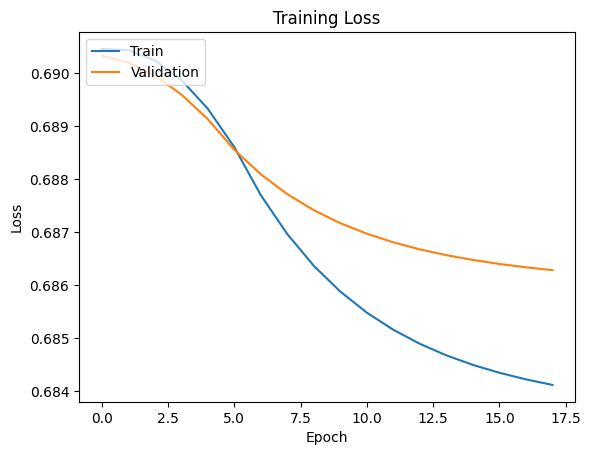

In [16]:
# Training results visualization
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Recommendation:

In [17]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
product_weights = extract_weights('product_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

#### Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [18]:
# popularity_threshold = 50
# df_anime= df_anime.query('Members >= @popularity_threshold')
# print(df_anime.shape)
# df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

# 1: Item Based Recommendation

In [19]:
# def find_similar_animes(name, n=10, return_dist=False, neg=False):
#     try:
#         anime_row = df_anime[df_anime['Name'] == name].iloc[0]
#         index = anime_row['anime_id']
#         encoded_index = anime_encoder.transform([index])[0]
#         weights = anime_weights
#         dists = np.dot(weights, weights[encoded_index])
#         sorted_dists = np.argsort(dists)
#         n = n + 1            
#         if neg:
#             closest = sorted_dists[:n]
#         else:
#             closest = sorted_dists[-n:]
#         print('Animes closest to {}'.format(name))
#         if return_dist:
#             return dists, closest
        
#         SimilarityArr = []
        
#         for close in closest:
#             decoded_id = anime_encoder.inverse_transform([close])[0]
#             anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
#             anime_name = anime_frame['Name'].values[0]
#             english_name = anime_frame['English name'].values[0]
#             name = english_name if english_name != "UNKNOWN" else anime_name
#             genre = anime_frame['Genres'].values[0]
#             Synopsis = anime_frame['Synopsis'].values[0]
#             similarity = dists[close]
#             similarity = "{:.2f}%".format(similarity * 100)
#             SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
#         Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
#         return Frame[Frame.Name != name]
#     except:
#         print('{} not found in Anime list'.format(name))

# pd.set_option('display.max_colwidth', None)

In [20]:
# find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)  # That Time I Got Reincarnated as a Slime

In [21]:
# find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

In [22]:
# find_similar_animes('One Punch Man', n=5, neg=False)

In [23]:
# find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5084 entries, 392 to 3927
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_id               5084 non-null   int64  
 1   uniq_id                  5084 non-null   object 
 2   crawl_timestamp          5084 non-null   object 
 3   product_url              5084 non-null   object 
 4   product_name             5084 non-null   object 
 5   product_category_tree    5084 non-null   object 
 6   pid                      5084 non-null   object 
 7   retail_price             5084 non-null   float64
 8   discounted_price         5084 non-null   float64
 9   image                    5084 non-null   object 
 10  is_FK_Advantage_product  5084 non-null   bool   
 11  description              5084 non-null   object 
 12  product_rating           5084 non-null   object 
 13  overall_rating           5084 non-null   object 
 14  brand                    50

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Part 1: Finding Similar Users
#### In this part, we randomly select a user from the dataset and find similar users based on their anime preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [24]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [36]:
# Select a random user
ratings_per_user = df_products.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user <10].sample(1, random_state=None).index[0])
# random_user=1;
print(random_user)
# Find similar users to the random user
similar_users = find_similar_users(random_user, n=5, neg=False)
similar_users = similar_users[similar_users.similarity >.1]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

124


,similar_users,similarity
4,82,0.218859
3,222,0.186502
2,169,0.183788
1,37,0.168121
0,47,0.157303


In [37]:
def clean_and_extract_unique_words(input_string):
    # Remove unwanted characters and split the string into words
    words = input_string.replace(' >> ', ' ').replace("'", "").replace('"', '').replace('[', '').replace(']', '').replace('(', '').replace('&', '').split()

    # Convert words to lowercase and create a set to store unique words
    unique_words = set(word.lower() for word in words)

    return list(unique_words)

input_string = df_products['product_category_tree'][1]
unique_words = clean_and_extract_unique_words(input_string)

print(unique_words)
df_products['product_category_tree']=df_products['product_category_tree'].apply(clean_and_extract_unique_words)
df_products.head(1)


AttributeError: 'list' object has no attribute 'replace'

## Part 2: User Preferences
#### This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [38]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_categories):
    category_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_categories)
    plt.figure(figsize=(10, 8))
    plt.imshow(category_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    products_viewed_by_user = df_products[df_products['user_id'] == user_id]
    
    
    if products_viewed_by_user.empty:
        print("User #{} has not viewed any product.".format(user_id))
        return pd.DataFrame()
    
    user_rating_percentile = np.percentile(products_viewed_by_user.rating, 75)
    
    products_viewed_by_user = products_viewed_by_user[products_viewed_by_user.rating >= 1]
#     print(products_viewed_by_user)
    
    top_products_user = (
        products_viewed_by_user.sort_values(by="rating", ascending=False)
        .product_id.values
    )
    
#     print(top_products_user)
    
    product_df_rows = df_products[df_products["product_id"].isin(top_products_user)]
#     print(anime_df_rows)
    product_df_rows = product_df_rows[["product_name", "product_category_tree"]]
#     print(product_df_rows)
    
    if verbose != 0:
        print("User \033[1m{}\033[0m has viewed {} product(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(products_viewed_by_user), products_viewed_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred categories----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in product_df_rows['product_category_tree']:
#             if isinstance(genres, str):
#                 print(genres)
                for genre in genres:
#                     print(genre)
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return product_df_rows

User 124 has viewed 5 product(s) with an average rating of 6.6/10

----- Preferred categories----- 



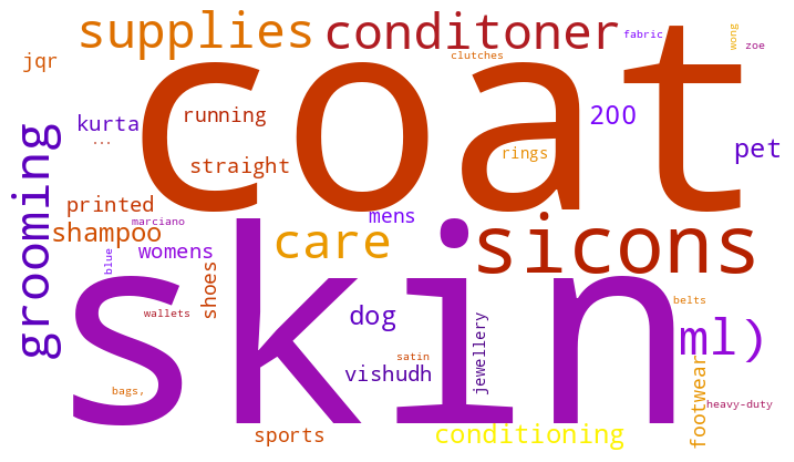

,product_name,product_category_tree
221,Sicons Conditioning Conditoner Dog Shampoo,"[coat, skin, sicons, supplies, conditoner, car..."
1195,JQR JQR Sports Shoes Running Shoes,"[running, jqr, footwear, shoes, mens, sports]"
219,Sicons Conditioning Conditoner Dog Shampoo,"[coat, skin, sicons, supplies, conditoner, car..."
1212,JQR JQR Sports Shoes Running Shoes,"[running, jqr, footwear, shoes, mens, sports]"
220,Sicons Conditioning Conditoner Dog Shampoo,"[coat, skin, sicons, supplies, conditoner, car..."
...,...,...
234,Sicons Conditioning Conditoner Dog Shampoo,"[coat, skin, sicons, supplies, conditoner, car..."
429,Vishudh Printed Women's Straight Kurta,"[womens, kurta, vishudh, printed, straight]"
409,Vishudh Printed Women's Straight Kurta,"[womens, kurta, vishudh, printed, straight]"
226,Sicons Conditioning Conditoner Dog Shampoo,"[coat, skin, sicons, supplies, conditoner, car..."


In [39]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
user_pref


## Part 3: Recommending Animes for a User
#### In the final part, we recommend animes to the selected user based on the preferences of similar users. The get_recommended_animes function iterates through the list of similar users, retrieves their preferences, and identifies animes that are not present in the preferences of the selected user. It then generates a list of recommended animes along with their genres and a brief synopsis. The output is a dataframe containing the recommended animes for the user.

In [40]:
def get_recommended_products(similar_users, user_pref, n=10):
    recommended_products = []
    product_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["product_name"].isin(user_pref["product_name"].values)]
            product_list.append(pref_list.product_name.values)
       
         
    if len(product_list) == 0:
        print("No product recommendations available for the given users.")
        return pd.DataFrame()
    
    product_list = pd.DataFrame(product_list)
    
    sorted_list = pd.DataFrame(pd.Series(product_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    product_count = df_products['product_id'].value_counts()
    
    for i, product_name in enumerate(sorted_list.index):
        if isinstance(product_name, str):
            try:
                product_id = df_products[df_products.product_name == product_name].product_id.values[0]
                category = df_products[df_products.product_name == product_name].product_category_tree.values[0]
                description = df_products[df_products.product_name == product_name].description.values[0]
                n_user_pref = product_count.get(product_id, 0)  # Get the total count of users who have watched this anime
                recommended_products.append({
                    "n": n_user_pref,
                    "product_name": product_name, 
                    "category": category, 
                    "description": description
                })
            except:
                pass
    return pd.DataFrame(recommended_products)

In [41]:
# Get recommended animes for the random user
recommended_products = get_recommended_products(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_products
# df_products[df_products['user_id']==1]


> Top recommendations for user: 124


,n,product_name,category,description
0,39,Elegance Polyester Multicolor Abstract Eyelet ...,"[polyester, furnishing, curtains, abstract, ac...",Key Features of Elegance Polyester Multicolor ...
1,22,FabHomeDecor Fabric Double Sofa Bed,"[bed, finish, futons, living, beds, fabric, do...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,14,MASARA Solid Women's Straight Kurta,"[womens, kurta, masara, straight, solid]",Key Features of MASARA Solid Women's Straight ...
3,36,Liza Women Wedges,"[womens, wedges, liza, footwear, women]",Key Features of Liza Women Wedges Occasion: Ca...
4,34,House This Queen Cotton Duvet Cover,"[bed, cotton, furnishing, linen, this, house, ...",Key Features of House This Queen Cotton Duvet ...
5,30,Diviniti DG Royal Ornamental Size 4.5 Murgan J...,"[idols, diviniti, handicrafts, table, showpiec...",Diviniti DG Royal Ornamental Size 4.5 Murgan J...
6,29,BeYOUtiful Copper Repouss�� - Man With Dhol Sh...,"[showpieces, home, festive, decor, beyoutiful,...",Buy BeYOUtiful Copper Repouss�� - Man With Dho...
7,28,Bengal Blooms Rose Artificial Plant with Pot,"[3..., plant, pot, bengal, rose, blooms, artif...",Key Features of Bengal Blooms Rose Artificial ...
8,16,Riva Carpets Cotton Free Bath Mat Classic Shag...,"[furnishing, linen, bath, home, mats]",Riva Carpets Cotton Free Bath Mat Classic Shag...
9,34,Kennel Rubber Dumbell With Bell - Small Rubber...,"[toys, pet, supplies, comfort]",Buy Kennel Rubber Dumbell With Bell - Small Ru...
